In [1]:
# Modeling
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from scipy import stats
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import seaborn as sns

# Feature Selection
import xgboost as xgb
from sklearn.decomposition import PCA

# Evaluate Algorithms

In [14]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
from acquire_prepare import acquire_oil
from acquire_prepare import prep_data

import model
from model import lregression_test
from model import rregression_test
from model import pregression_test
import numpy as np
import pandas as pd

# Visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import sys 

**Let's bring in the DataFrame**

In [3]:
df = acquire_oil()
df = prep_data(df)

**(Rows, Columns)**

In [4]:
df.shape

(7888, 60)

**We need to make sure the numberic types are correct**

In [5]:
numerics = ['int64', 'float64']

num_df = df.select_dtypes(include=numerics)
num_df.columns

Index(['api14', 'proppant_ppf', 'frac_fluid_gpf', 'gross_perfs', 'frac_stages',
       'oil_gravity', 'peak_boepd', 'oil_hist', 'gas_hist', 'gor_hist',
       'ip90_boeqpd', 'tvd', 'sur_lat', 'sur_long', 'well_id', 'mid_point_lat',
       'mid_point_long', 'recovery', 'recovery_per_foot', 'months_active',
       'recovery_per_month', 'vintage', 'vintage_bin', 'encoded_direction',
       'encoded_frac_fluid_type', 'encoded_county', 'encoded_oper',
       'encoded_formation', 'encoded_lateral_class', 'scaled_direction',
       'scaled_frac_fluid_type', 'scaled_county', 'scaled_oper',
       'scaled_formation', 'scaled_lateral_class', 'scaled_proppant_ppf',
       'scaled_frac_fluid_gpf', 'scaled_gross_perfs', 'scaled_frac_stages',
       'scaled_oil_gravity', 'scaled_gor_hist', 'scaled_tvd',
       'scaled_mid_point_lat', 'scaled_mid_point_long', 'scaled_vintage'],
      dtype='object')

In [6]:
num_df = num_df.drop(columns=['gas_hist', 'recovery', 'recovery_per_foot', 
                              'recovery_per_month', 'api14',
                              'sur_long', 'sur_lat', 'mid_point_lat', 'mid_point_long',
                              'well_id', 'oil_hist'])

### Use LabelEncoder to encode county and frak_fluid_type

In [7]:
encoder = LabelEncoder()

encoder.fit(df.county)
num_df['county'] = encoder.transform(df.county)

num_df.head()

,proppant_ppf,frac_fluid_gpf,gross_perfs,frac_stages,oil_gravity,peak_boepd,gor_hist,ip90_boeqpd,tvd,months_active,...,scaled_frac_fluid_gpf,scaled_gross_perfs,scaled_frac_stages,scaled_oil_gravity,scaled_gor_hist,scaled_tvd,scaled_mid_point_lat,scaled_mid_point_long,scaled_vintage,county
30,1311.78809,1642.58887,3977.0,0.0,0.0,61.408554,1738.53259,47.452900,10021.0,33,...,0.547863,0.292627,0.000000,0.0,0.087056,0.745943,0.614855,0.580622,0.966667,0
31,1088.56238,1493.36900,7283.0,0.0,0.0,416.961182,1381.57100,351.796700,9764.0,66,...,0.498082,0.536127,0.000000,0.0,0.069179,0.726813,0.517410,0.581774,0.916667,0
32,951.97060,1369.34363,7382.0,0.0,0.0,838.371765,1961.41300,688.525400,10798.0,64,...,0.456706,0.543419,0.000000,0.0,0.098218,0.803781,0.587606,0.571086,0.916667,0
33,1155.36267,1299.68433,7382.0,31.0,0.0,438.325684,1325.53870,406.427765,9506.0,63,...,0.433468,0.543419,0.442857,0.0,0.066373,0.707608,0.592304,0.570250,0.916667,0
34,1284.25537,1596.72742,7050.0,0.0,0.0,443.969543,2816.79077,289.934052,10138.0,59,...,0.532564,0.518966,0.000000,0.0,0.141055,0.754652,0.576165,0.563362,0.933333,0


In [8]:
encoder = LabelEncoder()
encoder.fit(df.frac_fluid_type)
num_df['frac_fluid_type'] = encoder.transform(df.frac_fluid_type)
num_df.head()

,proppant_ppf,frac_fluid_gpf,gross_perfs,frac_stages,oil_gravity,peak_boepd,gor_hist,ip90_boeqpd,tvd,months_active,...,scaled_gross_perfs,scaled_frac_stages,scaled_oil_gravity,scaled_gor_hist,scaled_tvd,scaled_mid_point_lat,scaled_mid_point_long,scaled_vintage,county,frac_fluid_type
30,1311.78809,1642.58887,3977.0,0.0,0.0,61.408554,1738.53259,47.452900,10021.0,33,...,0.292627,0.000000,0.0,0.087056,0.745943,0.614855,0.580622,0.966667,0,7
31,1088.56238,1493.36900,7283.0,0.0,0.0,416.961182,1381.57100,351.796700,9764.0,66,...,0.536127,0.000000,0.0,0.069179,0.726813,0.517410,0.581774,0.916667,0,3
32,951.97060,1369.34363,7382.0,0.0,0.0,838.371765,1961.41300,688.525400,10798.0,64,...,0.543419,0.000000,0.0,0.098218,0.803781,0.587606,0.571086,0.916667,0,0
33,1155.36267,1299.68433,7382.0,31.0,0.0,438.325684,1325.53870,406.427765,9506.0,63,...,0.543419,0.442857,0.0,0.066373,0.707608,0.592304,0.570250,0.916667,0,3
34,1284.25537,1596.72742,7050.0,0.0,0.0,443.969543,2816.79077,289.934052,10138.0,59,...,0.518966,0.000000,0.0,0.141055,0.754652,0.576165,0.563362,0.933333,0,7


### Standardize Numeric Data

In [9]:
scaled_df = num_df.copy()

scaled_df['proppant_ppf'] = (scaled_df.proppant_ppf - scaled_df.proppant_ppf.min()) / (scaled_df.proppant_ppf.max() - scaled_df.proppant_ppf.min())
scaled_df['frac_fluid_gpf'] = (scaled_df.frac_fluid_gpf - scaled_df.frac_fluid_gpf.min()) / (scaled_df.frac_fluid_gpf.max() - scaled_df.frac_fluid_gpf.min())
scaled_df['tvd'] = (scaled_df.tvd - scaled_df.tvd.min()) / (scaled_df.tvd.max() - scaled_df.tvd.min())
scaled_df['frac_stages'] = (scaled_df.frac_stages - scaled_df.frac_stages.min()) / (scaled_df.frac_stages.max() - scaled_df.frac_stages.min())
scaled_df['oil_gravity'] = (scaled_df.oil_gravity - scaled_df.oil_gravity.min()) / (scaled_df.oil_gravity.max() - scaled_df.oil_gravity.min())
scaled_df['peak_boepd'] = (scaled_df.peak_boepd - scaled_df.peak_boepd.min()) / (scaled_df.peak_boepd.max() - scaled_df.peak_boepd.min())
scaled_df['gor_hist'] = (scaled_df.gor_hist - scaled_df.gor_hist.min()) / (scaled_df.gor_hist.max() - scaled_df.gor_hist.min())
scaled_df['ip90_boeqpd'] = (scaled_df.ip90_boeqpd - scaled_df.ip90_boeqpd.min()) / (scaled_df.ip90_boeqpd.max() - scaled_df.ip90_boeqpd.min())
scaled_df['months_active'] = (scaled_df.months_active - scaled_df.months_active.min()) / (scaled_df.months_active.max() - scaled_df.months_active.min())
scaled_df['vintage'] = (scaled_df.vintage - scaled_df.vintage.min()) / (scaled_df.vintage.max() - scaled_df.vintage.min())

In [10]:
xgb_df = scaled_df.copy()

### XGBoost Feature Recommender

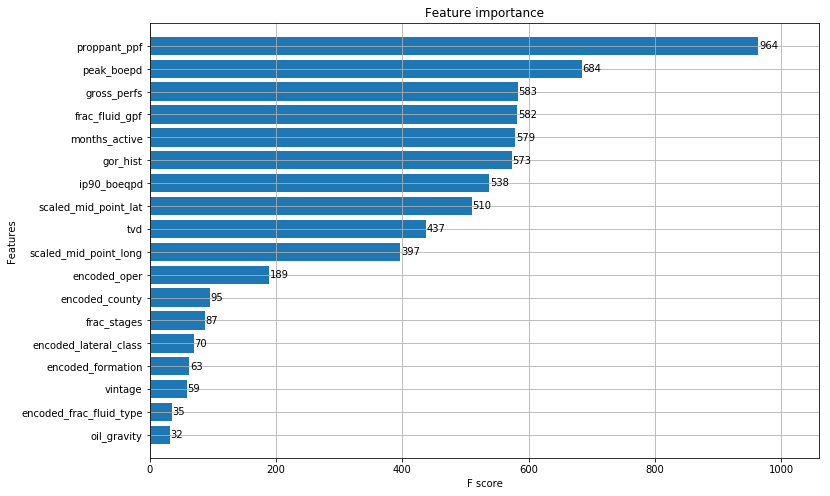

In [11]:
xgb_params = {
    'max_depth': 8,
    'seed' : 493
}

dtrain = xgb.DMatrix(xgb_df, df.oil_hist, feature_names=xgb_df.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=50)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,8))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

# Test Harness and Options

In [12]:
xfeatures = ['proppant_ppf', 'frac_fluid_gpf', 'gor_hist', 'tvd', 'sur_lat', 'mid_point_lat', 'mid_point_long', 'sur_long', 'encoded_oper', 'encoded_direction', 'vintage', 'gross_perfs']
yfeature = ['recovery']

### Results for the entire dataframe to use as a baseline before clustering

Logistic Regression Model:
This regression model accounts for 27.61% of the variance in recovery with the selected features.
-----
Cross-validation Scores: [0.28277988 0.26142233 0.27205654]
-----
The Coefficients of Variation: [[ 7.14209392e-03  8.23162872e-03  5.01202525e-03  1.20951032e-02
  -3.76089557e+02  4.04631748e+02  2.40284601e+03 -2.43618394e+03
  -1.00429824e-01  6.83751029e+01 -2.18224215e+00  2.02718153e-02]]


Ridge Regression Model:
          0         1         2         3         4         5         6  \
0  1.046551  0.433649  0.247309 -0.132729 -1.560104 -1.587416  1.056572   
1 -0.028968 -0.233080  2.295205  0.177006 -0.296365 -0.329169  0.748032   
2 -1.680174 -0.905092 -0.109942 -0.006100  1.065733  1.050908 -1.077727   
3 -1.263488  1.628841  0.834497  0.251022 -0.248400 -0.224229  0.718003   
4  0.660058  0.245798  0.443945 -0.164832 -1.177907 -1.149162  1.168217   
5  0.192254  0.322474  0.549370  0.283719  0.008724 -0.006883  0.656479   
6 -0.022166  0.463185

TypeError: ufunc 'add' did not contain a loop with signature matching types dtype('<U21') dtype('<U21') dtype('<U21')

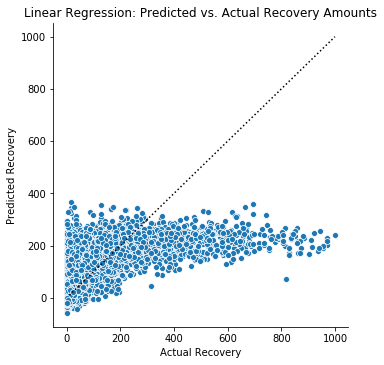

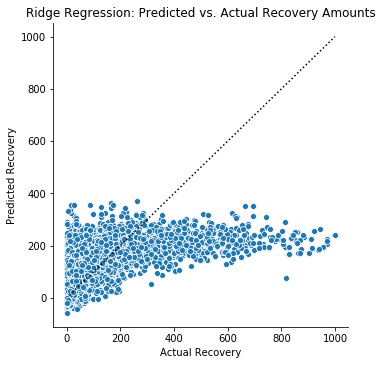

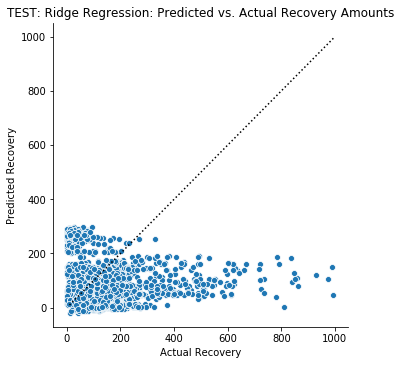

In [15]:
model.run_models(df, xfeatures, yfeature, 0.70)

**Let's Cluster by our Top Seven features per our XGBoost function**

In [ ]:
col_list = ['scaled_proppant_ppf', 'scaled_gross_perfs', 'scaled_tvd', 'scaled_frac_fluid_gpf', 
            'scaled_gor_hist', 'encoded_oper', 'scaled_vintage']

**We now have a new dataframe with an added column "cluster_id"**

In [ ]:
df = model.create_kclusters(df, col_list, 3, 'cluster_id')

**Let's see how many oberservations we have in each cluster**

In [ ]:
df.cluster_id.value_counts()

In [ ]:
df.to_excel('CapstoneDataFinal.xlsx')

# ALL Regression Types on Each Cluster

### Cluster 0: 2331 Oberservations 

In [ ]:
cluster_zero = df[df['cluster_id'] == 0]

In [ ]:
model.run_models(cluster_zero, xfeatures, yfeature, 0.70)

### Cluster 1: 3693 Observations

In [ ]:
cluster_one = df[df['cluster_id'] == 1]

In [ ]:
model.run_models(cluster_one, xfeatures, yfeature, 0.70)

### Cluster 2: 1864 Observations

In [ ]:
cluster_two = df[df['cluster_id'] == 2]

In [ ]:
model.run_models(cluster_two, xfeatures, yfeature, 0.70)

## Interpret and report results

# Improve Results

## Algorithm Tuning

## Ensemble Methods

### Bagging

### Boosting

### Blending

## Extreme Feature Engineering